<h1 align="center">Modelado Inverso Cole-Cole</h1>
<div align="right">Por David A. Miranda, PhD<br>2020</div>

Con este Jupyter Notebook aprenderás a realizar el modelado inverso de Cole-Cole con el algoritmo descrito en [Miranda et. al. 2014](https://link.springer.com/article/10.1007/s10008-013-2262-5).  Para el modelo a invertir deberás escoger el número de dispersiones $N$.  El resultado del modelo inverso serán los parámetros de múltiples dispersiones Cole-Cole descritas por:

$$ Z = Q_\infty + \sum_{\lambda = 1}^{\lambda = N} \left[ \frac{\Delta Q_\lambda}{1 + (j\omega \tau_\lambda)^{1-\alpha_\lambda}} \right] $$

## 1. Importa las librerias

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.optimize import basinhopping 

## 2. Datos de entrada para el modelado inverso

In [2]:
N = 1 # Número de dispresiones
f = [ 1000, 2154, 4642, 10000, 21544, 46416, 100000, 215443, 464159, 1000000] # Frecuencia
R = [190, 189, 187, 183, 171, 148, 123, 109, 103, 101] # Parte real de la impedancia
I = [ -2.6,  -5.1,  -10.0 , -19.0, -30.5, -38.3, -32.7, -20.6, -11.3,  -5.8] # Parte imaginaria de la impedancia

## 3. Modelo inverso
El modelo inverso propuesto por [Miranda et. al. 2014](https://link.springer.com/article/10.1007/s10008-013-2262-5) se basa en la optimización del error cuadrático medio.  En esta implementación se tomó $\varsigma = 0$, es decir, se optimiza solo la función $OF_1$, definida en la ecuación (23) del artículo.

Los parámetros se organizan en una lista, con el siguiente orden.  El número de dispersiones se infiere del número de parámetros.

$$ p = [R_\infty, \Delta Q_1, \tau_1, \alpha_1, \Delta Q_2, \tau_2, \alpha_2, ..., \Delta Q_N, \tau_N, \alpha_N] $$

In [3]:
def multi_Cole_Cole(p, f):
    n = len(f) - 1
    N = int((len(p) - 1) / 3)
    w = 2 * np.pi * np.array(f)
    if  3 * N + 1 != len(p):
        print('Error! The number of parameters must be 3 N + 1, where N is the number of dispersions.')
        return f * np.NaN
    if np.any(np.array(p) < 0):
        print('Error! The parameters must be positive values.')
        return f * np.NaN
    if np.any(~np.isfinite(p)):
        print('Error! The parameters must be finite values.')
        return f * np.NaN
    Z = np.zeros(n+1)
    Z += p[0]
    for k in range(1, 3*N, 3):
        DR = p[k]; tau = p[k+1]; a = p[k+2]
        Z = Z + DR / ( 1 + ( 1j * w * tau )**(1-a))
    return Z

In [4]:
def OF1(f, Z, p):
    if np.any(np.array(p) < 0): # Función de castigo
        return 100
    Zm = multi_Cole_Cole(p, f)
    of_R = ( 1 - Zm.real/Z.real )**2
    of_I = ( 1 - Zm.imag/Z.imag )**2
    return sum(of_R + of_I)

In [5]:
def plot(f, Z, fig=None, ax=None, dpi=120, marker='o', label=''):
    ax1 = ax
    if fig is None or ax is None:
        fig, ax1 = plt.subplots(dpi=dpi)
    color = 'tab:red'
    if label == '':
        ax1.semilogx(f,  Z.real, marker, color=color)
    if label != '':
        ax1.semilogx(f,  Z.real, marker, color=color, label=label)
    ax1.set_xlabel('Frecuencia [Hz]')
    ax1.set_ylabel(r'real{Z} $[\Omega]$', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.semilogx(f, -Z.imag, marker, color=color)
    ax2.set_ylabel(r'-imag{Z} $[\Omega]$', color=color) 
    ax2.tick_params(axis='y', labelcolor=color)

In [6]:
def func(p, f=[], Z=[]):
    return OF1(f, Z, p)

def modelo_inverso(f, R, I, N, niter=50):
    if int(N) != N:
        print('Error! N must be integer.')
        return []
    if np.std([len(v) for v in [f, R, I]]) != 0:
        print('Error! The length of the f, R, and I vector must be equal.')
        return (3*N+1)*[np.NaN]
    Ri  = min(R)
    Q   = max(R) - min(R)
    idx = np.argmax(np.abs(I))
    tau = 1/(2*np.pi*f[idx])
    a   = 0.5
    p0 = np.array([Ri] + N * [Q, tau, a])
    minimizer_kwargs = {
        'method': 'BFGS',
        'args': (f, np.array(R) + 1j * np.array(I))
        }
    p = basinhopping(func, p0, minimizer_kwargs=minimizer_kwargs, niter=niter)
    print(p)
    return p.x

## 4. Simulación

In [7]:
p = modelo_inverso(f, R, I, N)

                        fun: 0.0023291118342346163
 lowest_optimization_result:       fun: 0.0023291118342346163
 hess_inv: array([[ 1.00048502e+00, -1.66846493e-03, -6.60240995e-09,
        -6.56817999e-04],
       [-1.66846493e-03,  1.00362946e+00,  4.15908817e-08,
        -6.50877452e-03],
       [-6.60240995e-09,  4.15908817e-08,  1.03130102e-12,
        -3.52787373e-08],
       [-6.56817999e-04, -6.50877452e-03, -3.52787373e-08,
         1.70528082e-02]])
      jac: array([ 6.54919713e-04, -2.19741277e-03,  4.50468406e+03,  2.28519448e-02])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 708
      nit: 7
     njev: 116
   status: 2
  success: False
        x: array([1.00993998e+02, 8.90165935e+01, 3.19904419e-06, 1.01782167e-01])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 13
                       nfev: 9216
                        nit: 50
                   

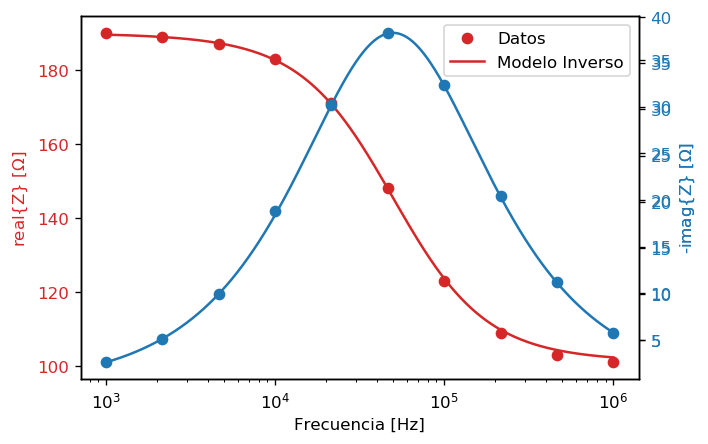

In [8]:
Z  = np.array(R) + 1j * np.array(I)
fm = np.logspace(np.log10(min(f)), np.log10(max(f)), 1000)
Zm = multi_Cole_Cole(p, fm)
fig, ax = plt.subplots(dpi=120)
plot(f, Z, fig=fig, ax=ax, label='Datos')
plot(fm, Zm, marker='', fig=fig, ax=ax, label='Modelo Inverso')
_ = ax.legend()

# 5. Pregunas de autoexplicación
Resuleva las siguientes preguntas de autoexplicación:
+ ¿Cuál es el propósito de cada método definido en el ítem 3?
+ ¿Cómo se cálcula la impedancia eléctrica con el método multi_Cole_Cole?
+ El método multi_Cole_Cole tiene implementado un algoritmo para detectar errores (verificación de parámetros), explique cada uno de los errores que detecta el algoritmo y de un ejemplo para cada posible error.
+ ¿Cuál es el propósito de agregar una verificación de errores?
+ Describa cómo el método OF1 implementa el cálculo de la ecuación (23) de [Miranda et. al. 2014](https://link.springer.com/article/10.1007/s10008-013-2262-5).
+ Si se tiene el método OF1, ¿por qué se define func? 
+ Modifique los métodos OF1 y modelo_inverso para que elimine la necesidad de utilizar func.
+ Describa los parámetros que recibe el método basinhopping.
+ Describa los parámetros de salida del método basinhopping.
+ A partir de los parámetros de salida de basinhopping, ¿cómo se puede verificar que la optimización convergió?
+ ¿Cómo se implementó el algoritmo propuesto por [Miranda et. al. 2014](https://link.springer.com/article/10.1007/s10008-013-2262-5) con el método modelo_inverso? ¿Éxisten algunas diferencias entre el algoritmo propuesto y el implementado?
+ Genere datos numéricos para más de una dispersión y aplique el modelado inverso empleando el método modelo_inverso.  ¿Qué tan parecidos son los valores de los parámetros obtenidos con los valores esperados? Explique.

End